# Creating a Portfolio Using Modern Portfolio Theory

**Credit for some of the code goes to Jay Chen and his "Python for Finance" book.

## Goal:
The main goal of this project is to use Modern Portfolio Theory, which was devised by Nobel Prize winning economist Harry Markowitz, to create the optimal portfolio given a list of stocks. I would like this to be used by anyone regardless of programming skill. In order to do this I will automate everything except the list of stocks that are inputed so that the user doesn't have to try and decipher what is happening in the code. The number of stocks you choose to input doesn't matter. The algorithm should work regardless.

## Define and Collect Stock Info.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import datetime as dt

style.use('ggplot')

# Define and collect stock data
start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data = pd.DataFrame()
# ------------------------------------------------------------------------------------------------------------------
# ---------------------The list of stocks is the only thing you need to change--------------------------------------
# ------------------------------------------------------------------------------------------------------------------

stocks = ['spy','spyg','spyv','eem','gld','hdv','smh','qqq','iwy','vcr','xhb']

# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

for stock in stocks:
    data[stock] = web.DataReader(stock, 'yahoo', start, end)['Adj Close']

# Find daily returns, avg. return, and standard deviation
for i in range(len(stocks)):
    data['return_'+stocks[i]] = data[stocks[i]].pct_change()
    data['stdev_'+stocks[i]] = data['return_'+stocks[i]].std()
    data['mean_'+stocks[i]] = data['return_'+stocks[i]].mean()

copy = data.copy()
copy = copy.dropna()
data = data.dropna() # first row of returns is missing which will mess up later calculations

## Define Parameters for Analysis

In [2]:
# List standard deviations
stdev = pd.DataFrame()
for i in range(len(stocks)):
    stdev['stdev_'+stocks[i]] = data['stdev_'+stocks[i]]

stdev = stdev.reset_index(drop = True)
stdev = stdev[-1:]
sigma = np.array(stdev)
sigma = sigma.tolist()
sigma = sigma[0]

# List correlation coefficients
ret = pd.DataFrame()
for i in range(len(stocks)):
    ret['return_'+stocks[i]] = data['return_'+stocks[i]]

rho = np.cov(ret)

# List average returns
mean = pd.DataFrame()
for i in range(len(stocks)):
    mean['mean_'+stocks[i]] = data['mean_'+stocks[i]]

mean = mean.reset_index(drop = True)
mean = mean[-1:]
r = np.array(mean)
r = r.tolist()
r = r[0]

# Define a function to randomly form portfolio weights (Credit: Jay Chen)
def xlist(n):
    x = []
    for i in range(n):
        x.append(random.random())
    return [i/sum(x) for i in x]

# Variance-covariance matrix (Credit: Jay Chen)
def covmat(sigma, rho):
    n = len(sigma)
    sigma = np.matrix(sigma)
    sigmatrix = np.dot(np.transpose(sigma), sigma)
    temp = np.ones([n,n])
    for i in range(n):
        j = i + 1
        while j < n:
            temp[i,j] = rho[i][j-i-1]
            j+=1
    rhomatrix = np.multiply(temp, np.transpose(temp))
    varcov = np.multiply(rhomatrix, sigmatrix)
    return varcov

# Define the portfolio (Credit: Jay Chen)
def port(x,r,sigma,rho):
    port_return = np.dot(x,np.transpose(r))
    x = np.matrix(x)
    xSig = np.dot(x,covmat(sigma,rho))
    temp = np.dot(xSig,np.transpose(x))
    port_risk = temp.item()**.5
    return [port_return, port_risk]

## Monte Carlo Analysis

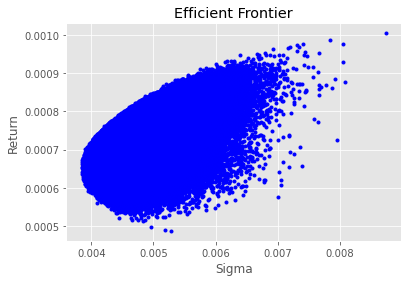

In [3]:
# Portfolio outputs
risk = []
returns = []
portlist = []

# Monte Carlo simulation on portfolio
for i in range(1000000):
    allocation = xlist(len(sigma))
    portlist.append(allocation)
    portfolio = port(allocation,r,sigma,rho)
    risk.append(portfolio[1])
    returns.append(portfolio[0])
    
plt.plot(risk, returns, 'b.')
plt.title('Efficient Frontier')
plt.xlabel('Sigma')
plt.ylabel('Return')
plt.show()

## Optimal Portfolio
In order to find the best allocation of our funds, we need to calculate something called the Sharpe Ratio. This ratio tells you how much return you can expect for every additional unit of risk. Therefore, the higher the Sharp Ratio, the better the portfolio.

In [4]:
data = pd.DataFrame({'Return': returns, 
                   'Sigma': risk,
                   'Portfolio': portlist})

# Risk-free rate as of 2/27/2021
r_f = ((1+.0206)/(1+.014)-1)/365 # (((1 + 10-yr T-bill rate)/(1 + inflation)) - 1)/365

data['Sharpe'] = (data['Return']-r_f)/data['Sigma']
data['Annual_Sharpe'] = data['Sharpe']*252**.5

data = data.sort_values(by='Sharpe', ascending = False) # Highest Sharpe = best performance (highest CAL slope)
data = data.reset_index(drop = True)
data = data.rename(columns={'Return': 'Return (%)',
                           'Sigma': 'Sigma (%)'})
data['Return (%)'] = data['Return (%)']*100
data['Sigma (%)'] = data['Sigma (%)']*100
data['Annual_R (%)'] = data['Return (%)']*252

data.head()

,Return (%),Sigma (%),Portfolio,Sharpe,Annual_Sharpe,Annual_R (%)
0,0.074023,0.408714,"[0.09065629062587896, 0.10541057921035181, 0.0...",0.176748,2.805787,18.653716
1,0.073425,0.405540,"[0.1032422127855267, 0.10796672850598947, 0.05...",0.176657,2.804350,18.503063
2,0.076066,0.420499,"[0.10738682688850892, 0.1186486039109934, 0.06...",0.176653,2.804283,19.168585
3,0.073536,0.406460,"[0.09548915768260392, 0.09996473166713231, 0.1...",0.176532,2.802352,18.531126
4,0.073600,0.407352,"[0.08786843158225169, 0.09047858370753906, 0.0...",0.176302,2.798702,18.547232


### A Better Look at the Best Portfolio Allocation

In [5]:
current = pd.DataFrame()
for i in range(len(stocks)):
    current[stocks[i]] = copy[stocks[i]]

current = current[-1:].reset_index(drop = True)
current = current.transpose().reset_index().rename(columns = {0 : 'Current Price',
                                                              'index': 'Ticker'})
best = data['Portfolio'][0]
lists = [stocks, best]

df = pd.concat([pd.Series(x) for x in lists], axis = 1)
df = df.rename(columns={0: 'Ticker',
                  1: 'Weight (%)'})
df['Weight (%)'] = round(df['Weight (%)']*100,4)

invest = 10000
df['Investment'] = round(df['Weight (%)']/100*invest,2)
df['Shares'] = round(df['Investment']/current['Current Price'])

table = pd.merge(current, df, on = 'Ticker')

table

,Ticker,Current Price,Weight (%),Investment,Shares
0,spy,380.359985,9.0656,906.56,2.0
1,spyg,55.020000,10.5411,1054.11,19.0
2,spyv,35.880001,7.6907,769.07,21.0
3,eem,53.730000,6.7060,670.60,12.0
4,gld,161.809998,9.4161,941.61,6.0
5,hdv,89.559998,8.0368,803.68,9.0
6,smh,240.949997,10.1959,1019.59,4.0
7,qqq,314.140015,10.3382,1033.82,3.0
8,iwy,131.320007,10.7358,1073.58,8.0
9,vcr,283.519989,10.9596,1095.96,4.0
